###### Dataset Read and Loader

In [1]:
import torch
import cv2
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F

# This was needed for getting rid of from the errors that come out from "plt" errors
os.environ['KMP_DUPLICATE_LIB_OK']='True'

print("Cuda Avaliable :", torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class CaptchaDataset (torch.utils.data.Dataset):
    def __init__(self, root):
        
        self.root = root
        self.imgs = sorted(os.listdir(root))
        self.labels = [img.split(".")[0] for img in self.imgs]
        
        self.Dict = set(char for label in self.labels for char in label)
        
        # Vocabulary for inverting integers to characters after training
        v = sorted(list(self.Dict))
        v.insert(0, '[UNK]')
        
        self.Vocab = v
        
        
    def __getitem__(self, idx):
        
        img = cv2.imread(self.root + "/" + self.imgs[idx])
        
        #Resize the image width = 200, height = 50
        img = cv2.resize(img, (200, 50), interpolation = cv2.INTER_AREA)
        
        #Convert image to GrayScale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        #Add last channel
        img = np.expand_dims(img, axis=-1)
        
        #Normalize İmage
        img = img/255
        
        #Permute channels in order to use width as time dimension and pass to torch tensor
        img = img.transpose(1,0,2)
        img = torch.as_tensor(img)
        img = img.to(device)
        
        #Map label chars to integers and pass to torch tensor
        label = [(self.Vocab).index(char) for char in self.labels[idx]]
        label = torch.as_tensor(label)
        label = label.to(device)
        
        return img, label
       
    def __len__(self):
        return len(self.imgs)

Cuda Avaliable : True
cuda


###### Read and Load Dataset

In [2]:
#Read Data
data = CaptchaDataset("captcha_images_v2")

# Length of the Data
L = int(data.__len__())

#Split Dataset into train and test
train_dataset, test_dataset = torch.utils.data.random_split(data, [int(L*0.9), int(L*0.1)])

#Load Train and Test set
Train_Data = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
Test_Data = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

###### Visualize the Loaded Dataset

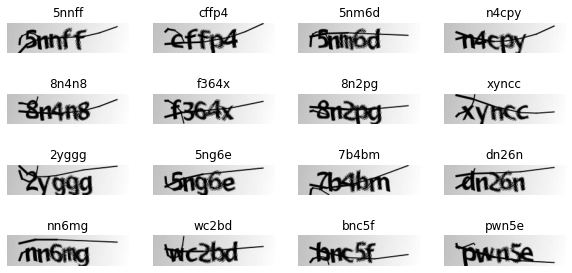

In [3]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
[images, labels] = next(iter(Train_Data))
images = images.cpu()
labels = labels.cpu()
for i in range(16):
    img = (images[i] * 255).numpy().astype("uint8")
    label = [data.Vocab[int(k)] for k in labels[i]]
    char_label = ""
    char_label = char_label.join(label)
    ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
    ax[i // 4, i % 4].set_title(char_label)
    ax[i // 4, i % 4].axis("off")
plt.show()

In [4]:
class Simple_OCR_model(nn.Module):
    def __init__(self):
        super(Simple_OCR_model, self).__init__()
        self.first_conv = nn.Conv2d(1, 32, kernel_size = (3,3), padding = "same")
        self.first_maxpool = nn.MaxPool2d(kernel_size = (2,2))
        self.second_conv = nn.Conv2d(32, 64, kernel_size = (3,3), padding = "same")
        self.second_maxpool = nn.MaxPool2d(kernel_size = (2,2))
        self.first_linear_layer = nn.Linear(768, 64)
        self.dropout = torch.nn.Dropout(p = 0.2)
        self.first_birectional_lstm = nn.LSTM(64, 128, batch_first = True, bidirectional = True, dropout=0.25)
        self.second_birectional_lstm = nn.LSTM(256, 64, batch_first = True, bidirectional = True, dropout=0.25)
        self.second_linear_layer = nn.Linear(128, len(data.Vocab) + 1)
        
    def forward(self, x, w, h):
        
        batch_size = x.shape[0]
        
        # Input shape to Conv Layers should be : (N, C_in, H_in, W_in)
        x = torch.permute(x, (0, 3, 2, 1)).float()
        
        # Convolutional Blocks
        x = self.first_conv(x)
        x = nn.ReLU()(x)
        x = self.first_maxpool(x)
        x = self.second_conv(x)
        x = nn.ReLU()(x)
        x = self.second_maxpool(x)
        
        #Reshape the output of convolutional blocks for RNN layers
        new_shape = (batch_size, (w // 4), (h // 4) * 64)
        
        x = torch.reshape(x, new_shape)
        
        x = self.first_linear_layer(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        
        # Recurrent layers
        x, (h_n_1, c_n_1) = self.first_birectional_lstm(x)
        
        x, (h_n_2, c_n_2) = self.second_birectional_lstm(x)
        
        #last layers
        x = self.second_linear_layer(x)
        #x = nn.Softmax()(x)
        
        return x

In [5]:
model = Simple_OCR_model()
model = model.to(device)

C:\Users\Admin\.conda\envs\botsort_env\lib\site-packages\torch\nn\modules\rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [6]:
#model.forward(next(iter(Train_Data))[0], w=200, h=50).log_softmax(2)

In [7]:
#model.eval()

###### Define the Train Loop

In [8]:
def train_loop(dataloader, model, optimizer):
    train_loss = 0.0
    size = len(dataloader.dataset)
    
    for batch, (X,y) in enumerate(dataloader):
        #Define width and height
        w = 200
        h = 50 
        
        # Compute prediction and loss
        pred = model(X, w, h)
        
        #print(pred.shape)
        
        # Batch_size, Input Sequence Length, Number of Classes :
        N, T, C = pred.shape
        pred = torch.permute(pred, (1, 0, 2))
        pred = pred.log_softmax(2)
        
        # Define lengths :
        input_lengths = torch.full((N,), T, dtype=torch.long)
        target_lengths = torch.full((N,), 5, dtype=torch.long)
        
        loss = F.ctc_loss(pred, y, input_lengths, target_lengths)
        
        # BackPropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss = train_loss + loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    print("Train loss :", train_loss)
            
def test_loop(dataloader, model):
    test_loss = 0.0
    
    for batch, (X,y) in enumerate(dataloader):
        
        #Define width and height
        w = 200
        h = 50 
        
        # Compute prediction and loss
        pred = model(X, w, h)
        
        # Batch_size, Input Sequence Length, Number of Classes :
        N, T, C = pred.shape
        pred = torch.permute(pred, (1, 0, 2))
        pred = pred.log_softmax(2)
        
        # Define lengths :
        input_lengths = torch.full((N,), T, dtype=torch.long)
        target_lengths = torch.full((N,), 5, dtype=torch.long)
        
        loss = F.ctc_loss(pred, y, input_lengths, target_lengths)
        
        test_loss = test_loss + loss.item()
    
    print("Test loss :", test_loss)
        
            
# Define Hyperparameters :
learning_rate = 0.001
num_epochs = 250

#loss_fn = torch.nn.functional.ctc_loss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [9]:
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(Train_Data, model, optimizer)
    test_loop(Test_Data, model)
print("Done!")

Epoch 1
-------------------------------
loss: 25.579494  [    0/  936]
Train loss : 343.49434757232666
Test loss : 342.17741560935974
Epoch 2
-------------------------------
loss: 3.293636  [    0/  936]
Train loss : 193.05974626541138
Test loss : 341.9841480255127
Epoch 3
-------------------------------
loss: 3.280350  [    0/  936]
Train loss : 193.01234340667725
Test loss : 341.8728747367859
Epoch 4
-------------------------------
loss: 3.282246  [    0/  936]
Train loss : 192.8182327747345
Test loss : 340.8333399295807
Epoch 5
-------------------------------
loss: 3.260345  [    0/  936]
Train loss : 192.9691939353943
Test loss : 341.3677363395691
Epoch 6
-------------------------------
loss: 3.300230  [    0/  936]
Train loss : 192.93590712547302
Test loss : 340.8254132270813
Epoch 7
-------------------------------
loss: 3.291750  [    0/  936]
Train loss : 192.92385935783386
Test loss : 341.168701171875
Epoch 8
-------------------------------
loss: 3.269927  [    0/  936]
Train l

Test loss : 215.29832518100739
Epoch 63
-------------------------------
loss: 1.884577  [    0/  936]
Train loss : 105.79181683063507
Test loss : 206.76056039333344
Epoch 64
-------------------------------
loss: 1.647745  [    0/  936]
Train loss : 99.76734781265259
Test loss : 199.90206706523895
Epoch 65
-------------------------------
loss: 1.589161  [    0/  936]
Train loss : 93.18778729438782
Test loss : 193.7157940864563
Epoch 66
-------------------------------
loss: 1.521979  [    0/  936]
Train loss : 87.50143122673035
Test loss : 187.52697336673737
Epoch 67
-------------------------------
loss: 1.396116  [    0/  936]
Train loss : 82.59675717353821
Test loss : 177.97627729177475
Epoch 68
-------------------------------
loss: 1.448372  [    0/  936]
Train loss : 78.5040123462677
Test loss : 181.59779581427574
Epoch 69
-------------------------------
loss: 1.487321  [    0/  936]
Train loss : 75.06219458580017
Test loss : 176.79534089565277
Epoch 70
------------------------------

Train loss : 8.55820282548666
Test loss : 146.47048787027597
Epoch 125
-------------------------------
loss: 0.104190  [    0/  936]
Train loss : 7.873367056250572
Test loss : 141.79047864302993
Epoch 126
-------------------------------
loss: 0.182761  [    0/  936]
Train loss : 7.921917203813791
Test loss : 153.35293379798532
Epoch 127
-------------------------------
loss: 0.119859  [    0/  936]
Train loss : 7.420721232891083
Test loss : 141.15002102032304
Epoch 128
-------------------------------
loss: 0.190770  [    0/  936]
Train loss : 7.416232202202082
Test loss : 146.66689337044954
Epoch 129
-------------------------------
loss: 0.081981  [    0/  936]
Train loss : 7.223271403461695
Test loss : 156.86695512384176
Epoch 130
-------------------------------
loss: 0.102196  [    0/  936]
Train loss : 5.928043395280838
Test loss : 142.32548707723618
Epoch 131
-------------------------------
loss: 0.092593  [    0/  936]
Train loss : 5.275138359516859
Test loss : 151.66681737825274
E

Test loss : 155.9567462867126
Epoch 186
-------------------------------
loss: 0.023207  [    0/  936]
Train loss : 2.2992014857009053
Test loss : 147.63774793967605
Epoch 187
-------------------------------
loss: 0.103127  [    0/  936]
Train loss : 3.058277596719563
Test loss : 162.8416433595121
Epoch 188
-------------------------------
loss: 0.042363  [    0/  936]
Train loss : 3.1857968270778656
Test loss : 160.82127474667504
Epoch 189
-------------------------------
loss: 0.024740  [    0/  936]
Train loss : 4.011473844759166
Test loss : 161.68027102667838
Epoch 190
-------------------------------
loss: 0.067955  [    0/  936]
Train loss : 3.5540382396429777
Test loss : 152.68297466356307
Epoch 191
-------------------------------
loss: 0.042654  [    0/  936]
Train loss : 2.8434927836060524
Test loss : 169.80442511290312
Epoch 192
-------------------------------
loss: 0.012012  [    0/  936]
Train loss : 3.3463959833607078
Test loss : 162.42670949967578
Epoch 193
------------------

Train loss : 2.290450927335769
Test loss : 187.42806849069893
Epoch 248
-------------------------------
loss: 0.019812  [    0/  936]
Train loss : 1.6288994383066893
Test loss : 179.961482386454
Epoch 249
-------------------------------
loss: 0.068603  [    0/  936]
Train loss : 2.079363575205207
Test loss : 171.183319889009
Epoch 250
-------------------------------
loss: 0.004704  [    0/  936]
Train loss : 2.032040301710367
Test loss : 182.36899742856622
Done!


In [80]:
test_batch_imgs, test_batch_labels = next(iter(Test_Data))

In [81]:
pred_batch = model.forward(test_batch_imgs, w = 200, h = 50 )

In [50]:
pred_batch.shape

torch.Size([1, 50, 21])

In [32]:
F.softmax(pred_batch, 2).argmax(2)

tensor([[13,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  2,  0, 11]],
       device='cuda:0')

In [33]:
test_batch_labels

tensor([[13,  1,  3,  6, 17]], device='cuda:0')

In [38]:
pred_batch.shape

torch.Size([1, 50, 21])

In [45]:
from beam_search import beam_search

In [57]:
chars = "0" + "".join(data.Vocab[1:])

In [58]:
chars

'02345678bcdefgmnpwxy'

In [67]:
len(chars)

20

In [65]:
torch.squeeze(pred_batch, dim=0).cpu().detach().numpy().shape

(50, 21)

In [72]:
pred_batch = F.softmax(pred_batch, 2)

In [82]:
import numpy as np
from beam_search import beam_search
from best_path import best_path

mat = torch.squeeze(pred_batch, dim=0).cpu().detach().numpy()
chars = chars = "0" + "".join(data.Vocab[1:])

print(f'Best path: "{best_path(mat, chars)}"')
print(f'Beam search: "{beam_search(mat, chars)}"')

Best path: "gn0c30n"
Beam search: ""


In [74]:
test_batch_labels

tensor([[14,  9,  2,  4, 15]], device='cuda:0')

In [79]:
chars[15]

'n'

In [66]:
mat.shape

(2, 3)